In [1]:
!pip install mne==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.9 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Data_processing.py to Data_processing.py


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from Data_processing import *
import math
from torch.autograd import Variable
from sklearn.metrics import f1_score

## **1. Definition of the model**

**a) Sub-parts**

Implement variance-preserving initialization (He or Kaiming initialization). Choosing mode as 'fan_in' preserves the magnitude of the variance of the weights in the forward pass. Choosing 'fan_out' preserves the magnitudes in the backwards pass.

In [4]:
def he_init(layer):
  if isinstance(layer, nn.Conv2d):
    nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

In [5]:
# Code edited from https://github.com/amirhosseinh77/UNet-AerialSegmentation/blob/main/model.py

class DoubleConv(nn.Module):
    """Consists of Conv -> BN -> ReLU -> Conv -> BN -> ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='valid'):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
        )

    def forward(self,x):
      return self.double_conv(x)


class Down(nn.Module):
    """Consists of MaxPool then DoubleConv"""

    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            DoubleConv(in_channels, out_channels, kernel_size)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Consists of transpose convolution then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2)
        self.conv = DoubleConv(in_channels, out_channels, kernel_size, stride)

    def forward(self, x1, x2):
        """x1, x2 (Tensor) : n_batch, channels, height, width"""

        # Crop x2 tensor to match the height and width of x1
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # Skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Consists of transpose convolution then double conv"""

    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1), nn.BatchNorm2d(num_features=out_channels))

    def forward(self, x):
        return self.conv(x)


**b) Assembly of sub-parts**

In [6]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes): # n_classes should be 2, because of binary classification : foreground and background class (gray or black)
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64, kernel_size=3)
        self.down1 = Down(64, 128, kernel_size=3)
        self.down2 = Down(128, 256, kernel_size=3)
        self.down3 = Down(256, 512, kernel_size=2)
        self.down4 = Down(512, 1024, kernel_size=2) # Kernel size of 2 to fit in (height, width)

        self.up1 = Up(1024, 512, kernel_size=2)
        self.up2 = Up(512, 256, kernel_size=2)
        self.up3 = Up(256, 128, kernel_size=3)
        self.up4 = Up(128, 64, kernel_size=(12,57), stride=(4,2))
        self.outc = OutConv(64, n_classes)

        self.apply(he_init)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x) # 2 channels containing the probabilities of gray and black
        return logits

In [ ]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1,n_classes=2).to(device)
summary(model, (1, 128, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 190]             640
       BatchNorm2d-2         [-1, 64, 126, 190]             128
              ReLU-3         [-1, 64, 126, 190]               0
            Conv2d-4         [-1, 64, 124, 188]          36,928
       BatchNorm2d-5         [-1, 64, 124, 188]             128
              ReLU-6         [-1, 64, 124, 188]               0
        DoubleConv-7         [-1, 64, 124, 188]               0
         MaxPool2d-8           [-1, 64, 62, 94]               0
            Conv2d-9          [-1, 128, 60, 92]          73,856
      BatchNorm2d-10          [-1, 128, 60, 92]             256
             ReLU-11          [-1, 128, 60, 92]               0
           Conv2d-12          [-1, 128, 58, 90]         147,584
      BatchNorm2d-13          [-1, 128, 58, 90]             256
             ReLU-14          [-1, 128,

## **2. Model training**

**a) Weighted focal loss** $$l_{i}=-\alpha_{i}(1-p_{i})^{\gamma}log(p_{i}),$$ where $p_{i}$ is given by the sigmoid function (softmax for multi-class classification).

In [7]:
# Code edited from https://github.com/amirhosseinh77/UNet-AerialSegmentation/blob/main/losses.py

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input, target):
        alpha = label_weights(target).view(-1,1)

        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target.to(torch.int64))
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        logpt = logpt * Variable(alpha)

        loss = -1 * (1-pt)**self.gamma * logpt

        if self.reduction == 'mean':
          return loss.mean()
        elif self.reduction == 'sum':
          return loss.sum()
        elif self.reduction == 'none':
          return loss
        else:
            raise ValueError("Invalid reduction option. Use 'mean', 'sum', or 'none'.")


In [ ]:
# === Can be ignored ===
class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha, gamma, reduction='mean'):
      """
      Computes a class-weighted version of the focal loss

      Args:
          alpha (Tensor): Weighting factor in range (0,1) to balance
                  black vs gray examples.
          gamma (float): Exponent of the modulating factor (1 - pi) to
                  balance easy vs hard examples.
          reduction (str): Specifies the reduction to apply to the output. 'mean'(default), 'sum' or 'none'

      Returns:
          Loss tensor with the reduction option applied.
      """
      super().__init__()
      self.alpha = alpha
      self.gamma = gamma
      self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.binary_cross_entropy_with_logits(input, target, weight=self.alpha, reduction='none') # -ai*log(pi)
        pi = torch.exp(-ce_loss/self.alpha)
        focal_loss = (1-pi) ** self.gamma * ce_loss

        if self.reduction == 'mean':
          return focal_loss.mean()
        elif self.reduction == 'sum':
          return focal_loss.sum()
        elif self.reduction == 'none':
          return focal_loss
        else:
            raise ValueError("Invalid reduction option. Use 'mean', 'sum', or 'none'.")


**b) Some functions**

In [58]:
def label_weights(target):
    N = target.shape[0]*25
    freq_min = torch.sum(target == 1) / N
    weights = torch.where(target==0, freq_min.float(), (1-freq_min).float())
    return weights


def predict(output):
    """
    Predicts each pixel's class (i.e. the decoded visual stimulus) from the UNet's output

    Args:
        output (Tensor): n_batch, depth 2, height and width 5 (output of the U-Net)

    Returns:
        pred (Tensor): n_batch, height and width 5
    """
    pred = torch.argmax(output,dim=1)
    return pred


def accuracy(prediction, target):
    """
    Computes the accuracy of the prediction

    Args:
        prediction (Tensor): predicted stimulus (n_batch, height and width 5)
        target (Tensor): target stimulus (n_batch, height and width 5)

    Returns:
        accuracy (float)
    """
    N = prediction.shape[0]
    acc = 0 if not torch.all(torch.eq(prediction, target)) else 1
    return acc / N

def soft_accuracy(prediction, target, reduction='mean'):
    """
    Computes the weighted pixel-wise accuracy of the prediction

    Args:
        prediction (Tensor): predicted stimulus (n_batch, height and width 5)
        target (Tensor): target stimulus (n_batch, height and width 5)

    Returns:
        pixel-wise accuracy (float)
    """
    N = prediction.shape[0]
    weights = label_weights(target)
    acc = weights*(prediction==target)
    if reduction == 'mean':
        return torch.mean(acc).cpu().float()
    elif reduction == 'none':
        return (acc / N).cpu()


**c) Train**

In [9]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    """
    @param model: torch.nn.Module
    @param criterion: torch.nn.modules.WeightedFocalLoss
    @param dataset_train: torch.utils.data.DataLoader
    @param dataset_test: torch.utils.data.DataLoader
    @param optimizer: torch.optim.Optimizer (AdamW)
    @param scheduler: torch.optim.lr_scheduler (CosineAnnealingLR(optimizer, T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,)
    @device:
    """
    model.train()
    loss_history = []
    accuracy_history = []
    soft_accuracy_history = []
    f1_history = []
    lr_history = []

    for batch_idx, (data,target) in enumerate(train_loader) :

      data = data.to(device)
      target = target.to(device)

      # Forward pass
      optimizer.zero_grad()
      output = model(data)

      # Compute the gradient
      loss = criterion(output,target)
      loss.backward()

      # Update the parameters of the model with a gradient step
      optimizer.step()
      scheduler.step()

      pred = predict(output)
      acc = accuracy(pred, target)
      soft_acc = soft_accuracy(pred, target)
      f1 = f1_score(target.view(-1).cpu(), pred.view(-1).cpu())

      loss_float = loss.item()
      loss_history.append(loss_float)
      accuracy_history.append(acc)
      soft_accuracy_history.append(soft_acc)
      f1_history.append(f1)

      lr_history.append(scheduler.get_last_lr()[0])

      if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
          print(
              f"Train Epoch: {epoch}-{batch_idx:03d} "
              f"batch_loss={loss_float:0.2e} "
              f"batch_acc={acc:0.3f} "
              f"batch_soft_acc={soft_acc:0.3f} "
              f"batch_f1={f1:0.3f} "
              f"lr={scheduler.get_last_lr()[0]:0.3e} "
          )

    return loss_history, accuracy_history, soft_accuracy_history, f1_history, lr_history


In [10]:
@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    f1 = 0
    soft_acc = 0

    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss += criterion(output, target).item() * len(data)
        pred = predict(output)
        correct += accuracy(pred, target)
        soft_acc += soft_accuracy(pred, target)
        f1 += f1_score(target.view(-1).cpu(), pred.view(-1).cpu())

    f1 /= len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)

    print(
        "Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Soft accuracy: {:.0f}%, F1 score: {}".format(
            val_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
            100.0 * soft_acc / len(val_loader.dataset),
            f1,
        )
    )
    return val_loss, correct / len(val_loader.dataset), soft_acc / len(val_loader.dataset), f1


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        pred = predict(output)

        data = np.split(data.cpu().numpy(), len(data))
        print(loss)
        loss = np.split(loss.cpu().numpy(), len(data))
        pred = np.split(pred.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        points.extend(zip(data, loss, pred, target))

        if num is not None and len(points) > num:
            break

    return points

@torch.no_grad()
def get_predictions(model, device, test_loader, criterion, num=None):
    model.eval()
    points = []
    losses = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        loss = criterion(output, target)
        pred = predict(output)
        point = {'target': target.detach().cpu().numpy(),
         'predict': pred.detach().cpu().numpy(),
         'loss': loss.detach().cpu().numpy()
         }
        losses.append(loss.detach().cpu().numpy())

        points.append(point)

    losses = np.array(losses)

    return points,losses

In [11]:
def run_training(
    model,
    optimizer,
    scheduler,
    criterion,
    num_epochs,
    optimizer_kwargs,
    train_loader,
    val_loader,
    device="cuda"
):

    # ===== Model =====
    model = model.to(device=device)

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    train_soft_acc_history = []
    train_f1_history = []
    val_loss_history = []
    val_acc_history = []
    val_soft_acc_history = []
    val_f1_history = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, train_soft_acc, train_f1, lrs = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        train_soft_acc_history.extend(train_soft_acc)
        train_f1_history.extend(train_f1)
        lr_history.extend(lrs)

        val_loss, val_acc, val_soft_acc, val_f1 = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_soft_acc_history.append(val_soft_acc)
        val_f1_history.append(val_f1)

    return sum(train_acc) / len(train_acc), val_acc, val_soft_acc, lr_history, train_loss_history, train_acc_history, train_soft_acc_history, train_f1_history, val_loss_history, val_acc_history, val_soft_acc_history, val_f1_history

In [33]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import mne

epochs, labels = get_data(file_path='/content/drive/MyDrive/Colab_Notebooks/ML/data/resampled_epochs_subj_0.pkl')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 2
batch_size = 5
data_kwargs = dict(
    epochs=epochs[:155],
    labels=labels[:155],
    batch_size=batch_size
)
train_loader, val_loader, test_loader = get_dataloaders(**data_kwargs)

Mounted at /content/drive
Dataset is split


In [31]:
# === Define the UNet and the training hyperparameters ===

model = UNet(n_channels=1, n_classes=2).to(device)
model = model.double()
optimizer_kwargs = dict(
    lr=1e-3,
    weight_decay=1e-2,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)
gamma = 1
criterion = FocalLoss(gamma=gamma)

In [34]:
# === Train ===
final_train_acc, val_acc, val_soft_acc, lr_history, train_loss_history, train_acc_history, train_soft_acc_history, train_f1_history, val_loss_history, val_acc_history, val_soft_acc_history, val_f1_history = run_training(model, optimizer, scheduler, criterion, num_epochs, optimizer_kwargs, train_loader, val_loader, device)


Train Epoch: 1-000 batch_loss=8.52e-02 batch_acc=0.000 batch_soft_acc=0.085 batch_f1=0.177 lr=9.729e-04 
Train Epoch: 1-001 batch_loss=9.97e-02 batch_acc=0.000 batch_soft_acc=0.154 batch_f1=0.289 lr=9.397e-04 
Train Epoch: 1-002 batch_loss=8.65e-02 batch_acc=0.000 batch_soft_acc=0.100 batch_f1=0.169 lr=8.946e-04 
Train Epoch: 1-003 batch_loss=4.09e-02 batch_acc=0.000 batch_soft_acc=0.054 batch_f1=0.103 lr=8.386e-04 
Train Epoch: 1-004 batch_loss=1.22e-01 batch_acc=0.000 batch_soft_acc=0.120 batch_f1=0.193 lr=7.735e-04 
Train Epoch: 1-005 batch_loss=7.72e-02 batch_acc=0.000 batch_soft_acc=0.104 batch_f1=0.193 lr=7.008e-04 
Train Epoch: 1-006 batch_loss=8.59e-02 batch_acc=0.000 batch_soft_acc=0.120 batch_f1=0.222 lr=6.227e-04 
Train Epoch: 1-007 batch_loss=5.47e-02 batch_acc=0.000 batch_soft_acc=0.072 batch_f1=0.133 lr=5.413e-04 
Train Epoch: 1-008 batch_loss=8.96e-02 batch_acc=0.000 batch_soft_acc=0.100 batch_f1=0.150 lr=4.587e-04 
Train Epoch: 1-009 batch_loss=6.15e-02 batch_acc=0.000 

In [38]:
# === Save the training outcomes ===
import pickle
import os
filename = str(num_epochs)+'_iters_'+str(batch_size)+'batch_'+str(gamma)+'gamma'
file_path = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Trials/{filename}.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)

data_tr_val = {
    "final_train_acc": final_train_acc,
    "val_acc": val_acc,
    "val_soft_acc": val_soft_acc,
    "lr_history": lr_history,
    "train_loss_history": train_loss_history,
    "train_acc_history": train_acc_history,
    "train_soft_acc_history": train_soft_acc_history,
    "train_f1_history": train_f1_history,
    "val_loss_history": val_loss_history,
    "val_acc_history": val_acc_history,
    "val_soft_acc_history": val_soft_acc_history,
    "val_f1_history": val_f1_history,
}
with open(file_path, 'wb') as fp: # Save the training and validating data
    pickle.dump(data_tr_val, fp)

file_path = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Models/{filename}.pth'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
model_params = torch.save(model.state_dict(), file_path) # Save the model

In [39]:
file_path = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Trials/{filename}.pkl'
with open(file_path, 'wb') as fp: # Save the training and validating data
    pickle.dump(data_tr_val, fp)

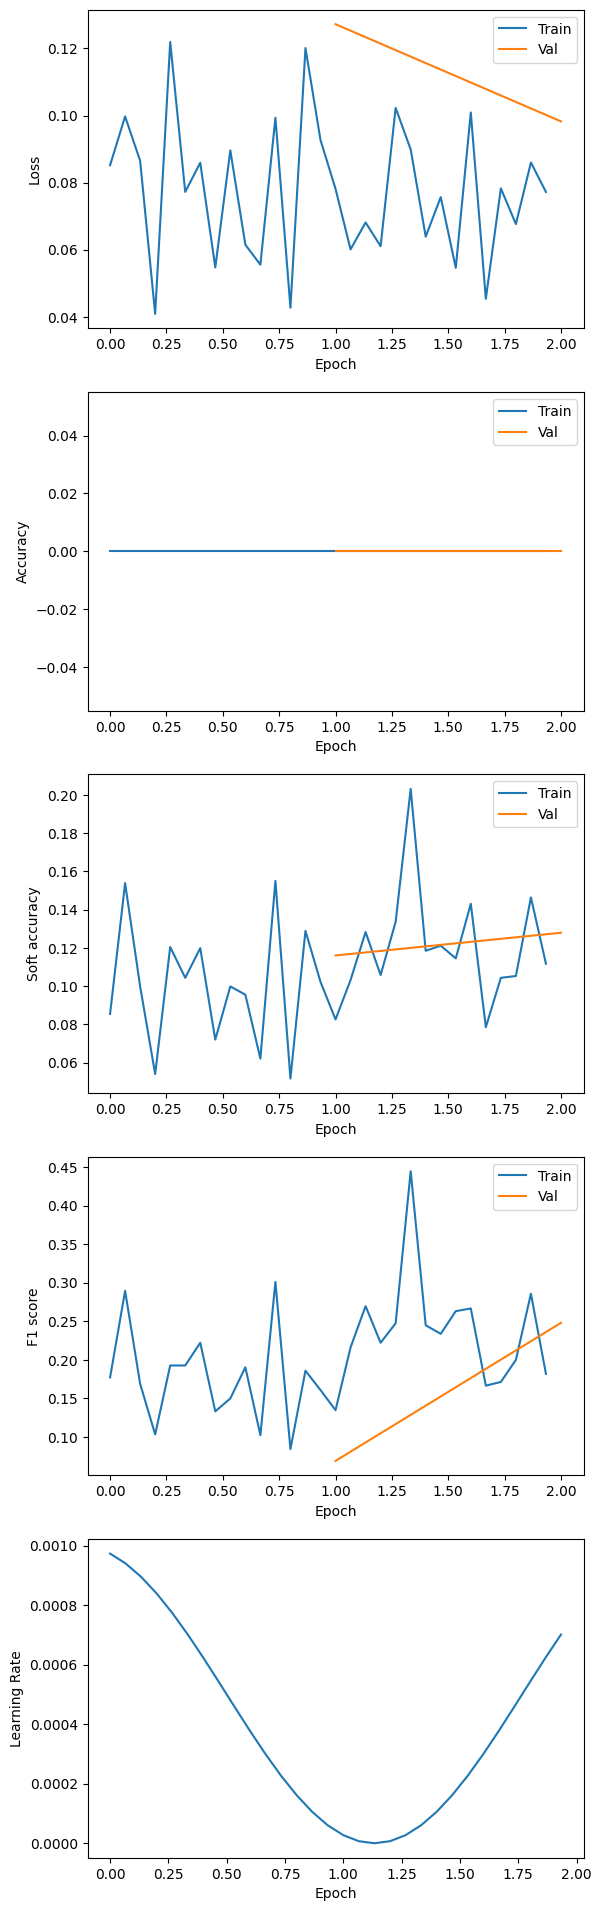

In [46]:
# ===== Training curves =====
train_acc_history = data_tr_val["train_acc_history"]
train_soft_acc_history = data_tr_val["train_soft_acc_history"]
val_acc_history = data_tr_val["val_acc_history"]
val_soft_acc_history = data_tr_val["val_soft_acc_history"]
train_f1_history = data_tr_val["train_f1_history"]
val_f1_history = data_tr_val["val_f1_history"]
train_loss_history = data_tr_val["train_loss_history"]
lr_history = data_tr_val["lr_history"]

n_train = len(train_acc_history)
t_train = num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)

file_path = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Plots/'
os.makedirs(os.path.dirname(file_path), exist_ok=True)

plt.figure(figsize=(6.4, 4.8*5))
plt.subplot(5, 1, 2)
plt.plot(t_train, train_acc_history, label="Train")
plt.plot(t_val, val_acc_history, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(5, 1, 4)
plt.plot(t_train, train_f1_history, label="Train")
plt.plot(t_val, val_f1_history, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("F1 score")

plt.subplot(5, 1, 1)
plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_val, val_loss_history, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(5, 1, 5)
plt.plot(t_train, lr_history)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

plt.subplot(5, 1, 3)
plt.plot(t_train, train_soft_acc_history, label="Train")
plt.plot(t_val, val_soft_acc_history, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Soft accuracy")
plt.savefig(file_path + f"{filename}.png")

In [52]:
# === Test the best model ===

best_gamma = 1
filename = str(num_epochs)+'_iters_'+str(batch_size)+'batch_'+str(best_gamma)+'gamma'
best_model_fp = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Models/{filename}.pth'

best_model = UNet(n_channels=1, n_classes=2).to(device)
best_model.load_state_dict(torch.load(best_model_fp))
best_model = best_model.double()
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
soft_acc_test_history = torch.zeros(1,5,5)

with torch.no_grad():
    for data, target in test_loader:
        data = data.to('cuda')
        target = target.to('cuda')
        output = best_model(data)
        pred = predict(output)
        soft_acc = soft_accuracy(pred, target, reduction='none')
        f1 = f1_score(target.view(-1).cpu(), pred.view(-1).cpu())
        soft_acc_test_history += soft_acc

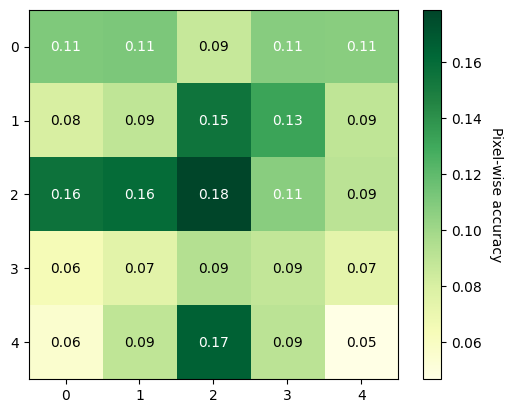

In [91]:
# === Plot pixel-wise mean accuracy and F1 score ===

soft_acc_test_mean = (soft_acc_test_history / len(test_loader)).numpy().squeeze()


background_intensity = np.mean(soft_acc_test_mean)
for i in range(soft_acc_test_mean.shape[0]):
    for j in range(soft_acc_test_mean.shape[1]):
        text_color = 'black' if soft_acc_test_mean[i, j] < background_intensity else 'white'
        plt.text(j, i, f'{soft_acc_test_mean[i, j]:.2f}', ha='center', va='center', color=text_color)
plt.imshow(soft_acc_test_mean, cmap='YlGn', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Pixel-wise accuracy', rotation=270, labelpad=15)
plt.show()

In [ ]:
def main():

    # === Load the data ===
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    import mne

    epochs, labels = get_data(file_path='/content/drive/MyDrive/Colab_Notebooks/ML/data/resampled_epochs_subj_0.pkl')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_epochs = 2
    batch_size = 5
    data_kwargs = dict(
        epochs=epochs[:155],
        labels=labels[:155],
        batch_size=batch_size
    )
    train_loader, val_loader, test_loader = get_dataloaders(**data_kwargs)

    # === Define the UNet and the training hyperparameters ===
    model = UNet(n_channels=1, n_classes=2).to(device)
    model = model.double()
    optimizer_kwargs = dict(
        lr=1e-3,
        weight_decay=1e-2,
    )
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )
    gamma = 1
    criterion = FocalLoss(gamma=gamma)

    # === Train ===
    final_train_acc, val_acc, val_soft_acc, lr_history, train_loss_history, train_acc_history, train_soft_acc_history, train_f1_history, val_loss_history, val_acc_history, val_soft_acc_history, val_f1_history = run_training(model, optimizer, scheduler, criterion, num_epochs, optimizer_kwargs, train_loader, val_loader, device)

    # === Save the training outcomes ===
    import pickle
    import os
    filename = str(num_epochs)+'_iters_'+str(batch_size)+'batch_'+str(gamma)+'gamma'
    file_path = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Trials/{filename}.pkl'
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    data_tr_val = {
        "final_train_acc": final_train_acc,
        "val_acc": val_acc,
        "val_soft_acc": val_soft_acc,
        "lr_history": lr_history,
        "train_loss_history": train_loss_history,
        "train_acc_history": train_acc_history,
        "train_soft_acc_history": train_soft_acc_history,
        "train_f1_history": train_f1_history,
        "val_loss_history": val_loss_history,
        "val_acc_history": val_acc_history,
        "val_soft_acc_history": val_soft_acc_history,
        "val_f1_history": val_f1_history,
    }
    with open(file_path, 'wb') as fp: # Save the training and validating data
        pickle.dump(data_tr_val, fp)

    file_path = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Models/{filename}.pth'
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    model_params = torch.save(model.state_dict(), file_path) # Save the model

    # === Training curves ===
    file_path = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Trials/{filename}.pkl'
    with open(file_path, 'wb') as fp: # Save the training and validating data
        pickle.dump(data_tr_val, fp)

    train_acc_history = data_tr_val["train_acc_history"]
    train_soft_acc_history = data_tr_val["train_soft_acc_history"]
    val_acc_history = data_tr_val["val_acc_history"]
    val_soft_acc_history = data_tr_val["val_soft_acc_history"]
    train_f1_history = data_tr_val["train_f1_history"]
    val_f1_history = data_tr_val["val_f1_history"]
    train_loss_history = data_tr_val["train_loss_history"]
    lr_history = data_tr_val["lr_history"]

    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    file_path = f'/content/drive/MyDrive/Colab_Notebooks/ML/UNet/Plots/'
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    plt.figure(figsize=(6.4, 4.8*5))
    plt.subplot(5, 1, 2)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(5, 1, 4)
    plt.plot(t_train, train_f1_history, label="Train")
    plt.plot(t_val, val_f1_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("F1 score")

    plt.subplot(5, 1, 1)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(5, 1, 5)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    plt.subplot(5, 1, 3)
    plt.plot(t_train, train_soft_acc_history, label="Train")
    plt.plot(t_val, val_soft_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Soft accuracy")
    plt.savefig(file_path + f"{filename}.png")



Indices of the 5 best losses: [ 5  2 17  0 18]
Indices of the 5 worst losses: [16  9 31 26 11]


KeyError: ignored

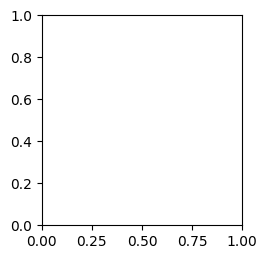

In [ ]:
# ===== Plot low/high loss predictions on validation set =====
points,losses = get_predictions(
    model,
    device,
    val_loader,
    criterion,
)

# Get the index of the 5 best losses
best_indices = np.argsort(losses)[:5]

# Get the index of the 5 worst losses
worst_indices = np.argsort(losses)[-5:]

print("Indices of the 5 best losses:", best_indices)
print("Indices of the 5 worst losses:", worst_indices)

plt.figure(figsize=(15, 6))
for k in range(5):
    plt.subplot(2, 5, k + 1)
    plt.imshow(points[k][predict], cmap="gray", interpolation='nearest')

    #plt.title(f"true={int(points[k][3])} pred={int(points[k][2])}")
    plt.subplot(2, 5, 5 + k + 1)
    plt.imshow(points[-k - 1][0][0, 0], cmap="gray")
    plt.title(f"true={int(points[-k-1][3])} pred={int(points[-k-1][2])}")

'''points.sort(key=lambda x: x[1])
plt.figure(figsize=(15, 6))
for k in range(5):
    plt.subplot(2, 5, k + 1)
    plt.imshow(points[k][0][0, 0], cmap="gray")
    plt.title(f"true={int(points[k][3])} pred={int(points[k][2])}")
    plt.subplot(2, 5, 5 + k + 1)
    plt.imshow(points[-k - 1][0][0, 0], cmap="gray")
    plt.title(f"true={int(points[-k-1][3])} pred={int(points[-k-1][2])}")'''

In [ ]:
# === To adapt ===

class EEGCNN(torch.nn.Module):
    def __init__(self):
        super(EEGCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 1))
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(5, 1))
        self.conv3 = torch.nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(10, 1))
        self.upconv1 = torch.nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(1, 5))
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(3, 1))
        self.relu = torch.nn.ReLU()
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=32)
        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=8)
        self.batchnorm3 = torch.nn.BatchNorm2d(num_features=1)
        return

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.pool1(x)
        x = self.upconv1(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGCNN().to(device)
summary(model, (1, 128, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 192]             128
              ReLU-2         [-1, 32, 126, 192]               0
       BatchNorm2d-3         [-1, 32, 126, 192]              64
         MaxPool2d-4          [-1, 32, 42, 192]               0
            Conv2d-5           [-1, 8, 38, 192]           1,288
              ReLU-6           [-1, 8, 38, 192]               0
       BatchNorm2d-7           [-1, 8, 38, 192]              16
         MaxPool2d-8           [-1, 8, 12, 192]               0
            Conv2d-9            [-1, 1, 3, 192]              81
      BatchNorm2d-10            [-1, 1, 3, 192]               2
        MaxPool2d-11            [-1, 1, 1, 192]               0
  ConvTranspose2d-12            [-1, 1, 1, 196]               6
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
-----------------------------------